In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Modify the parameters before running
---


In [2]:
normal_test_path = './data/norm_test.csv'
anomaly_test_path = './data/features_anom_scaled.csv'
window_size = 21
flattened_size = 777
model_path = './cae-21.pt'

---

In [3]:
norm_test = np.genfromtxt(normal_test_path, delimiter=',', dtype=np.float32)
anom_test = np.genfromtxt(anomaly_test_path, delimiter=',', dtype=np.float32)

In [4]:
norm_true = np.array(['NORMAL' for i in norm_test])
anom_true = np.array(['ANOMALOUS' for i in anom_test])
comb_true = np.concatenate((norm_true, anom_true))

In [5]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential( # input 21x37x1
            
            # conv1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2), # cols: (37-3)/2+1 = 18
                                                                                # rows: (21-3)/2+1 = 10
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 18/2=9, 10/2=5 => output is 5x9x16
            
            # conv2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), # cols: (9-3)/2+1 = 4  
                                                                                 # rows: (5-3)/2+1 = 2 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 4/2 = 2, 2/2 = 1 => output is 1x2x32 = 64
            
        )
        
        self.decoder = nn.Sequential(
            
            # convt1
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # convt2
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'

cae = CAE().to(device)
cae.load_state_dict(torch.load(model_path))
cae.eval()

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode=bilinear)
    (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2))
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()


In [7]:
def reconstruction_mse(true, pred):
    true = true.reshape(-1, flattened_size)
    pred = pred.reshape(-1, flattened_size)
    
    return np.sum((true-pred)**2, axis=1) / flattened_size

### testing against normal data

In [8]:
input_tensor = torch.from_numpy(norm_test.reshape(-1, 1, window_size, 37)).to(device)
reconstructed_window = cae(input_tensor)

In [9]:
loss_norm = reconstruction_mse(norm_test, reconstructed_window.detach().numpy())

### testing against anomalous data

In [10]:
input_tensor = torch.from_numpy(anom_test.reshape(-1, 1, window_size, 37)).to(device)
reconstructed_window = cae(input_tensor)

In [11]:
loss_anom = reconstruction_mse(anom_test, reconstructed_window.detach().numpy())

(0.0, 4.0)

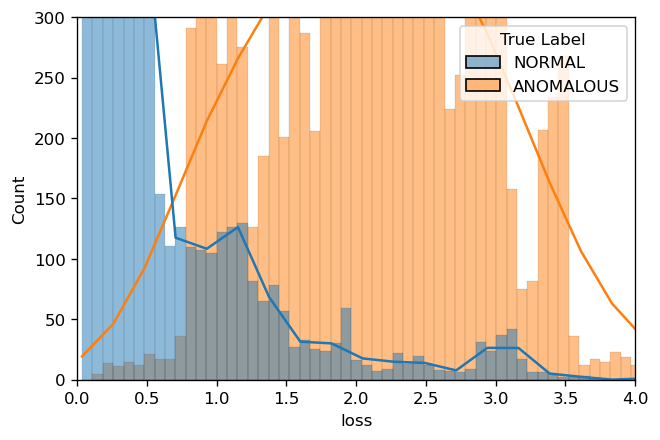

In [12]:
comb_loss = np.concatenate((loss_norm, loss_anom))
df_loss = pd.DataFrame({'True Label': comb_true, 'loss': comb_loss})
fig, ax = plt.subplots(dpi=120)
sns.histplot(data=df_loss, x='loss', hue='True Label', fill=True, kde=True, ax=ax)
ax.set_ylim(0, 300)
ax.set_xlim(0, 4)

### Adjust the threshold based on loss histplot
---

In [13]:
recon_loss_threshold = 0.7

---

In [14]:
prediction_norm = ['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_norm]
# unique, counts = np.unique(prediction, return_counts=True)
# prediction_counts = pd.DataFrame(np.array((unique, counts)).T, columns=['label', 'count'])

In [15]:
norm_pred = np.array(['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_norm])

In [16]:
df_prediction_norm = pd.DataFrame(data=np.array(prediction_norm), columns=['label'])
df_prediction_norm['label'].value_counts()

NORMAL       28949
ANOMALOUS     1754
Name: label, dtype: int64

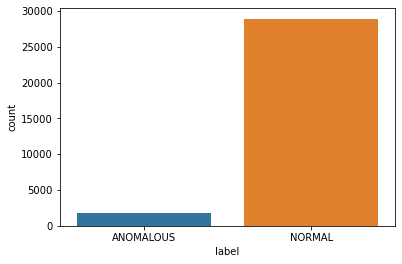

In [17]:
sns.countplot(x='label', data=df_prediction_norm)

In [18]:
prediction_anom = ['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_anom]

In [19]:
anom_pred = np.array(['NORMAL' if l < recon_loss_threshold else 'ANOMALOUS' for l in loss_anom])

In [20]:
df_prediction_anom = pd.DataFrame(data=np.array(prediction_anom), columns=['label'])
df_prediction_anom['label'].value_counts()

ANOMALOUS    13060
NORMAL         110
Name: label, dtype: int64

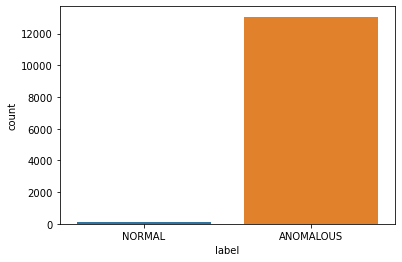

In [21]:
sns.countplot(x='label', data=df_prediction_anom)

In [22]:
comb_pred = np.concatenate((norm_pred, anom_pred))

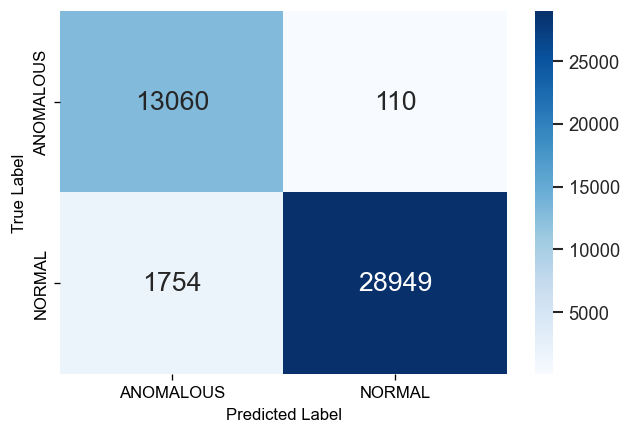

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(comb_true, comb_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(comb_true), index=np.unique(comb_true))
df_cm.index.name='True Label'
df_cm.columns.name = 'Predicted Label'
fig, ax = plt.subplots(dpi=120)
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size': 16}, fmt='d')

### testing against cherry-picked broken data (__DO NOT RUN__ for now)

In [24]:
failure_index = np.genfromtxt('./data/broken_index.csv', delimiter=',', dtype=int)

In [25]:
broken = np.genfromtxt('./data/features_broken_scaled.csv', delimiter=',', dtype=np.float32)

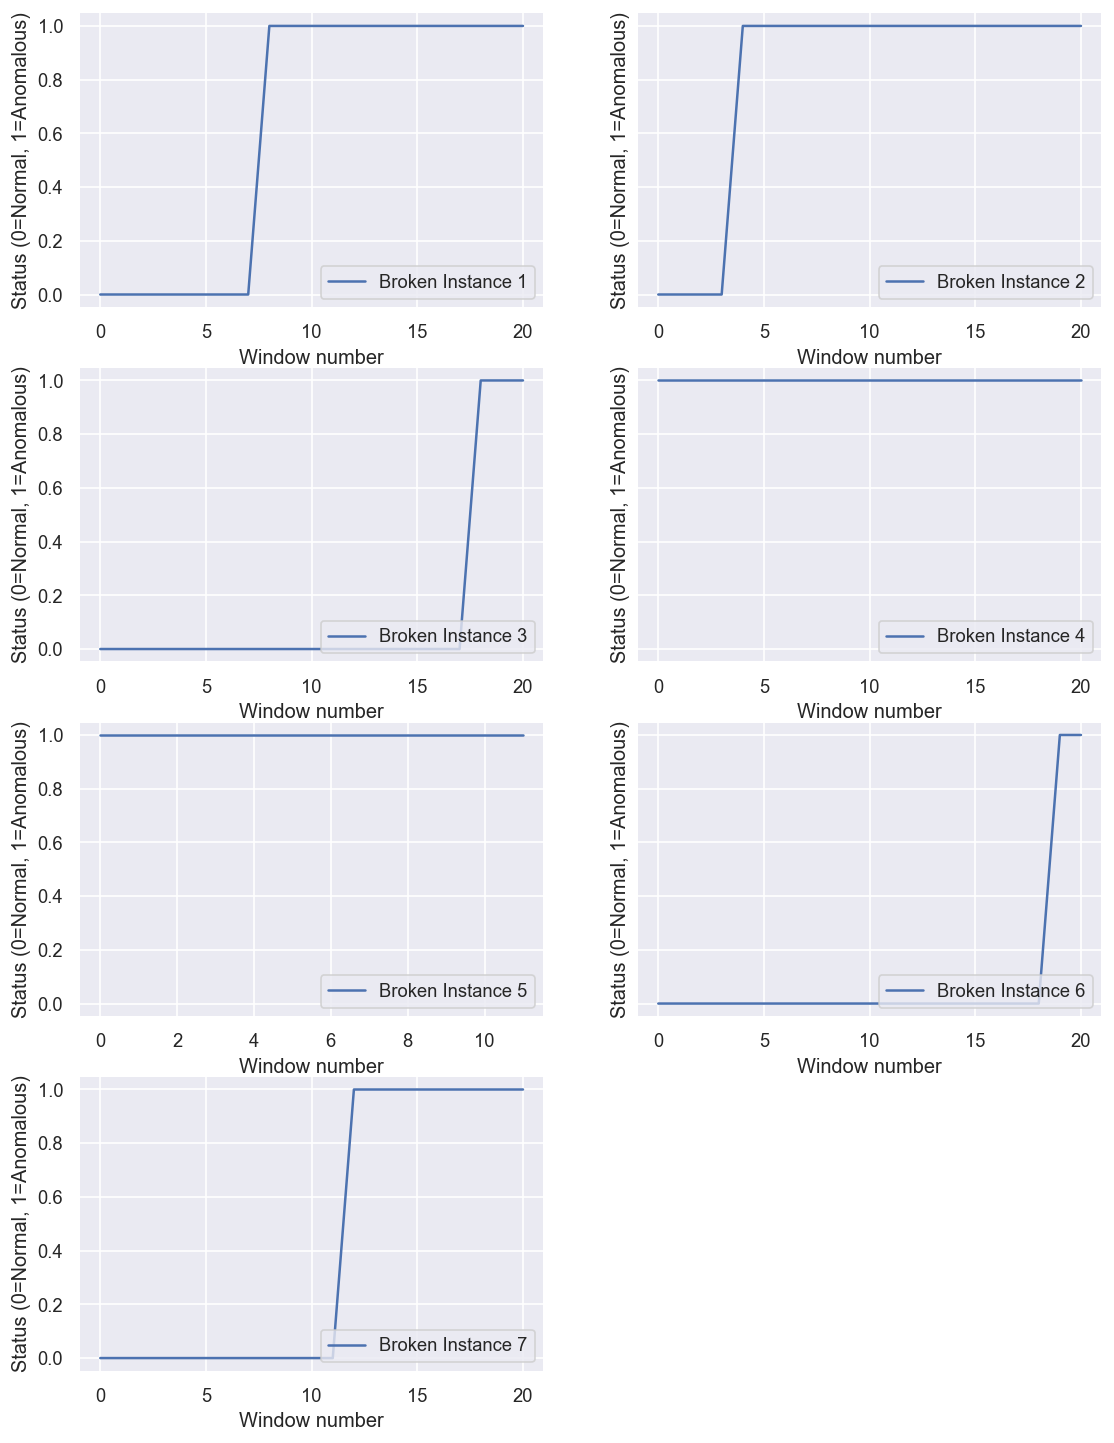

In [26]:
device='cpu'
fig, ax = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(11, 15), sharey=True)

for idx in range(0, 7):
    
    length = (failure_index==idx).sum()
    
    broken_subset = broken[failure_index==idx]

    input_tensor = torch.from_numpy(broken_subset.reshape(-1, 1, window_size, 37)).to(device)
    reconstructed_window = cae(input_tensor)

    loss = reconstruction_mse(broken_subset, reconstructed_window.detach().numpy())

    prediction = [0 if l < 0.5 else 1 for l in loss]

    ax[int(idx/2), idx%2].plot(np.arange(0, length,1), prediction, 'b-', label='Broken Instance {}'.format(idx+1))
    ax[int(idx/2), idx%2].legend(loc='lower right')
    ax[int(idx/2), idx%2].set_ylabel('Status (0=Normal, 1=Anomalous)')
    ax[int(idx/2), idx%2].set_xlabel('Window number')
    
fig.delaxes(ax[3, 1])